# E07 Spiking neural networks

In this week's homework, we are going to use the code from the tutorial and look at the effect of changes in its parameters in a more systematic way.

In [5]:
# If you do not have Brian installed, uncomment the following line and run this notebook cell
# %pip install brian2

In [1]:
# Import Brian and switch off its "code generation" facility
from brian2 import *
prefs.codegen.target = 'numpy'
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# This code is slightly adapted from the tutorial (lower number of neurons and shorter run time,
# and it additionally returns spike counts), see notes in the tutorial for more explanation about the code.

def run_sim(g, nu_ext_relative):
    start_scope()
    N_E = 1000
    # network parameters
    gamma = 0.25
    N_I = int(gamma * N_E)
    N = N_E + N_I
    epsilon = 0.1
    C_E = C_ext = int(epsilon * N_E)
    C_I = int(epsilon * N_I)

    # neuron parameters
    tau = 20 * ms; theta = 20 * mV; V_r = 10 * mV; tau_rp = 2 * ms

    # synapse parameters
    J = 0.1 * mV; D = 1.5 * ms

    # external stimulus
    nu_thr = theta / (J * C_E * tau)

    neurons = NeuronGroup(N,"dv/dt = -v/tau : volt (unless refractory)",
                          threshold="v > theta", reset="v = V_r",
                          refractory=tau_rp, method="exact")

    exc_neurons = neurons[:N_E]
    inh_neurons = neurons[N_E:]
    exc_synapses = Synapses(exc_neurons, neurons, on_pre="v += J", delay=D)
    exc_synapses.connect(i='k for k in sample(N_E, size=C_E)')
    inhib_synapses = Synapses(inh_neurons, neurons, on_pre="v += -g*J", delay=D)
    inhib_synapses.connect(i='k for k in sample(N_I, size=C_I)')

    nu_ext = nu_ext_relative * nu_thr
    external_poisson_input = PoissonInput(target=neurons, target_var="v",
                                          N=C_ext, rate=nu_ext, weight=J)

    rate_monitor = PopulationRateMonitor(neurons)
    exc_monitor = SpikeMonitor(exc_neurons)
    inh_monitor = SpikeMonitor(inh_neurons[:50])  # record 50 inhibitory neurons
    state_monitor = StateMonitor(exc_neurons, 'v', record=0)  # record membrane potential of one neuron
    run(0.5*second)
    
    return {'rate_t': rate_monitor.t, 'rate': rate_monitor.rate,
            'exc_spikes_t': exc_monitor.t, 'exc_spikes_i': exc_monitor.i, 'exc_spikes_count': exc_monitor.count, 
            'inh_spikes_t': inh_monitor.t, 'inh_spikes_i': inh_monitor.i, 'inh_spikes_count': inh_monitor.count,
            'state_t': state_monitor.t, 'state_v': state_monitor.v[0]}

In our model, each of the neurons in the network receives input via a `PoissonInput`. This models the summed effect of many neurons providing excitatory input to the cell, each spiking randomly according to a Poisson process. This is more efficient than actually simulating each of the external input cells and their synapses individually. 
The `nu_ext_relative` parameter that we provide to the `run_sim` function determines the *firing rate* of these external input neurons, i.e. higher values means that each neuron in the network gets more external input.

## Question: how does the network activity depend on the input rate and the strength of the inhibition?

To answer this question, we will first simulate the network several times, with different values for the external input rate `nu_ext_relative` and for the strength of the inhibitory synapses `g`. For each parameter combination below, store the *mean firing* rate of the excitatory neurons in the `firing_rate` matrix, and the *standard deviation of the firing rates* across excitatory neurons in the `firing_rate_stddev` matrix.

**Hints**:
  * The `results` dictionary returned by `run_sim`, contains an entry `exc_spikes_count` with an array containing the total number of spikes for each neuron.
  * Each simulation runs for 0.5s

In [4]:
# Parameters that we are varying
g_values = [0, 2, 4]
nu_ext_values = np.linspace(0, 5, 7)  # 7 values equally spaced between 0 and 5

# Empty matrices of the appropriate size
firing_rate = np.empty((len(nu_ext_values), len(g_values)))
firing_rate_stddev = np.empty((len(nu_ext_values), len(g_values)))

print('Running')
for nu_ext_index, nu_ext_value in enumerate(nu_ext_values):
    for g_index, g_value in enumerate(g_values):
        results = run_sim(g_value, nu_ext_value)
        # Store mean firing rate: 
        firing_rate[nu_ext_index, g_index] = np.mean(results['exc_spikes_count']/0.5)
        # Store standard deviation of firing rates
        firing_rate_stddev[nu_ext_index, g_index] = np.std(results['exc_spikes_count']/0.5)
        print('.', end='')  # Print a dot to show progress
print('\nFinished')

Running


TypeError: i argument must be int or array

We will now plot the mean firing rate and its standard deviation over neurons as a function of the external input rate, separately for the different strengths of inhibition.

**Hints**:
  * Use `plt.errorbar` to plot lines (for the mean firing rate) with error bars (for the standard deviation). The syntax is `plt.errorbar(x_values, y_values, error_values)`
  * If you add `label=f'g = {g_value}'` to the `plt.errorbar` call, the legend shows the strength of the inhibition in the label
  * Note that the error bars will most likely be very small and therefore almost invisible. For making sure your plotting code is correct, you can multiply the standard deviations by 10 for the plot – but make sure to remove this multiplication in the final version! 

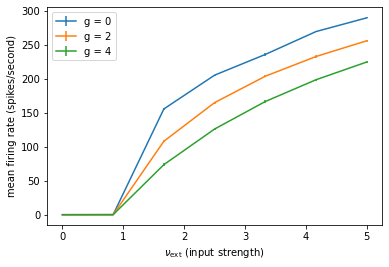

In [5]:
for g_index, g_value in enumerate(g_values):
    # TODO: Use plt.errorbar to plot the firing rate for the current value of g over the nu_ext_values, and add
    # error bars for the standard deviation of the firing rate across cells
    plt.errorbar(nu_ext_values, firing_rate[:, g_index], firing_rate_stddev[:, g_index], label=f'g = {g_value}')
    plt.legend()
    plt.ylabel('mean firing rate (spikes/second)')
    plt.xlabel(r'$\nu_\mathrm{ext}$ (input strength)');
    #          ^ The "r" is necessary so that Python interprets the string as a "raw string"
    #            Otherwise, e.g. \nu would be understood as \n (line break) + u, instead of
    #            LaTeX code for the greek character ν

## Question: How does the network activity change when connections are "truly random" (i.e.  each neuron can have a different number of inputs)?

As we briefly discussed in the tutorial, the above model uses random connections for each neuron, but each neuron receives the *same number of connections*. Make a copy of the `run_sim` function from above and rename it e.g. to `run_sim_random_input_number`. Then, change the two lines that connect the synapses to:
```
exc_synapses.connect(p=epsilon)
```
and
```
inh_synapses.connect(p=epsilon)
```
(This means, instead of having a fixed number of random connections, decide randomly for each possible pair of connections whether it should be made)

Now, use the parameter exploration and plotting code from above again, but this time call your new function `run_sim_random_input_number` – how do the results change? 

In [6]:
def run_sim_random_input_number(g, nu_ext_relative):
    N_E = 1000
    start_scope()
    # network parameters
    gamma = 0.25
    N_I = int(gamma * N_E)
    N = N_E + N_I
    epsilon = 0.1
    C_E = C_ext = int(epsilon * N_E)
    C_I = int(epsilon * N_I)

    # neuron parameters
    tau = 20 * ms; theta = 20 * mV; V_r = 10 * mV; tau_rp = 2 * ms

    # synapse parameters
    J = 0.1 * mV; D = 1.5 * ms

    # external stimulus
    nu_thr = theta / (J * C_E * tau)

    neurons = NeuronGroup(N,"dv/dt = -v/tau : volt (unless refractory)",
                          threshold="v > theta", reset="v = V_r",
                          refractory=tau_rp, method="exact")

    exc_neurons = neurons[:N_E]
    inh_neurons = neurons[N_E:]
    exc_synapses = Synapses(exc_neurons, neurons, on_pre="v += J", delay=D)
    exc_synapses.connect(p=epsilon)  # ← changed
    inhib_synapses = Synapses(inh_neurons, neurons, on_pre="v += -g*J", delay=D)
    inhib_synapses.connect(p=epsilon)  # ← changed

    nu_ext = nu_ext_relative * nu_thr
    external_poisson_input = PoissonInput(target=neurons, target_var="v",
                                          N=C_ext, rate=nu_ext, weight=J)

    rate_monitor = PopulationRateMonitor(neurons)
    exc_monitor = SpikeMonitor(exc_neurons)
    inh_monitor = SpikeMonitor(inh_neurons[:50])  # record 50 inhibitory neurons
    state_monitor = StateMonitor(exc_neurons, 'v', record=0)  # record membrane potential of one neuron
    run(1*second)
    
    return {'rate_t': rate_monitor.t, 'rate': rate_monitor.rate,
            'exc_spikes_t': exc_monitor.t, 'exc_spikes_i': exc_monitor.i, 'exc_spikes_count': exc_monitor.count, 
            'inh_spikes_t': inh_monitor.t, 'inh_spikes_i': inh_monitor.i, 'inh_spikes_count': inh_monitor.count,
            'state_t': state_monitor.t, 'state_v': state_monitor.v[0]}

In [7]:
# Parameters that we are varying
g_values = [0, 2, 4]
nu_ext_values = np.linspace(0, 5, 7)  # 7 values equally spaced between 0 and 5

# Empty matrices of the appropriate size
firing_rate = np.empty((len(nu_ext_values), len(g_values)))
firing_rate_stddev = np.empty((len(nu_ext_values), len(g_values)))

print('Running')
for nu_ext_index, nu_ext_value in enumerate(nu_ext_values):
    for g_index, g_value in enumerate(g_values):
        results = run_sim_random_input_number(g_value, nu_ext_value)
        # Store mean firing rate: 
        firing_rate[nu_ext_index, g_index] = np.mean(results['exc_spikes_count']/0.5) # ←
        # Store standard deviation of firing rates
        firing_rate_stddev[nu_ext_index, g_index] = np.std(results['exc_spikes_count']/0.5)  # ←
        print('.', end='')  # Print a dot to show progress
print('\nFinished')

Running
.....................
Finished


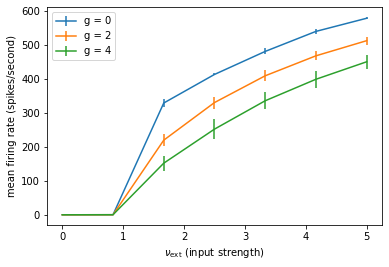

In [8]:
for g_index, g_value in enumerate(g_values):
    plt.errorbar(nu_ext_values, firing_rate[:, g_index], firing_rate_stddev[:, g_index], label=f'g = {g_value}')
    plt.legend()
    plt.ylabel('mean firing rate (spikes/second)')
    plt.xlabel(r'$\nu_\mathrm{ext}$ (input strength)');
    #          ^ The "r" is necessary so that Python interprets the string as a "raw string"
    #            Otherwise, e.g. \nu would be understood as \n (line break) + u, instead of
    #            LaTeX code for the greek character ν

**Answer:** Firing rates are higher and more variable

## Question: how many inputs does a neuron get under the random connection scheme

To answer this question we will create a toy network with random synapses, where the neurons and synapses do not actually do anything:

In [9]:
# Dummy code for a network of neurons/synapses that does not do anything
neurons = NeuronGroup(10000, '')
synapses = Synapses(neurons, neurons)
synapses.connect(p=0.1)

Print the minimum, maximum, and average number of synaptic inputs that each neuron receives. What is the *expected* average number for a network of $N$ neurons with connection probability $p$?

**Hint**:
  * The attribute `synapses.N_incoming_post` provides an array with the number of incoming synaptic connections for each neuron

In [10]:
print(f'The minimum number of incoming synapses is {min(synapses.N_incoming_post)}')
print(f'The maximum number of incoming synapses is {max(synapses.N_incoming_post)}')
print(f'The mean number of incoming synapses is {np.mean(synapses.N_incoming_post)}')

The minimum number of incoming synapses is 876
The maximum number of incoming synapses is 1114
The mean number of incoming synapses is 1000.1601


**Answer**: the expected average number is $N \cdot p$ (i.e. above $10000\cdot 0.1 = 1000$)

Plot a histogram showing the distribution of the number of incoming synapses per neuron:

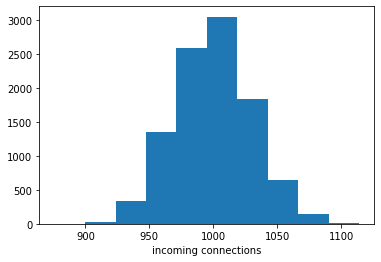

In [11]:
plt.hist(synapses.N_incoming_post);
plt.xlabel('incoming connections');